In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose)
import tensorflow as tf
from keras.optimizers import Adam
from scipy.misc import imresize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import ModelCheckpoint, CSVLogger

import pdb
import random
from PIL import Image
import numpy as np

%matplotlib inline

In [2]:
import keras
keras.__version__

'2.0.6'

## Prepare the data

In [3]:
# Set the necessary directories
data_dir = '../data/train/'
mask_dir = '../data/train_masks/'
all_images = os.listdir(data_dir)

In [4]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2)

In [5]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [6]:
def read_image_and_mask(data_dir, mask_dir, image):
    return (load_img(data_dir + image), 
            load_img(mask_dir + image.split('.')[0] + '_mask.gif'))

In [7]:
def show_image_and_mask(image, mask):
    plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

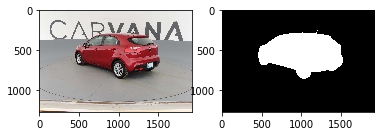

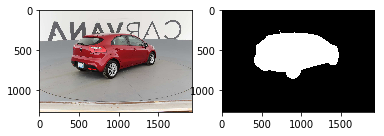

In [8]:
def random_horizontal_flip(image_pair, prob=0.5):
    """
    image: PIL image
    label: PIL image
    prob: the probability the image is flipped
    Note: wired behavior for transpose, result in NoneType error when use lambda and list
    """
    image, label = image_pair
    w, h = image.size
    flip_matrix = (-1, 0, w, 0, 1, 0)
    if random.random() < prob:
        image = image.transform(image.size, Image.AFFINE, flip_matrix)
        label = label.transform(image.size, Image.AFFINE, flip_matrix)
        assert image is not None and label is not None
    return image, label
    
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = random_horizontal_flip((image_, mask_), 1)
plt.figure()
plt.subplot(121)
plt.imshow(image_)
plt.subplot(122)
plt.imshow(mask_)

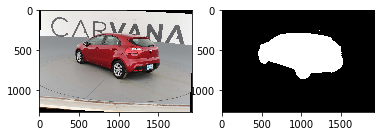

In [9]:
def random_rotate(image_pair, rotate_limit=(-30, 30)):
    image, label = image_pair
    rotate = random.uniform(rotate_limit[0], rotate_limit[1])
    image = image.rotate(rotate)
    label = label.rotate(rotate)
    return image, label

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_, mask_ = random_rotate((image_, mask_))
show_image_and_mask(image_, mask_)

array([ 255.,  255.,  255.], dtype=float32)

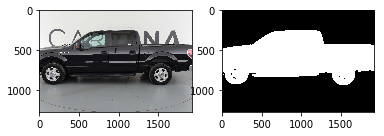

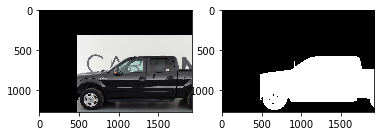

In [10]:
def shift_image(image, x, y):
    # https://stackoverflow.com/questions/17056209/python-pil-affine-transformation
    data = (1, 0, -x, 0, 1, -y)
    return image.transform(image.size, Image.AFFINE, data)
    
image_, mask_ = read_image_and_mask(data_dir, mask_dir, 'c502287be9f6_05.jpg')
show_image_and_mask(image_, mask_)
w, h = image_.size
image_ = shift_image(image_, w/4, h/4)
mask_ = shift_image(mask_, w/4, h/4)
show_image_and_mask(image_, mask_)

# The white value is 255
img_to_array(mask_)[1000,500]

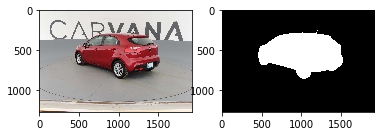

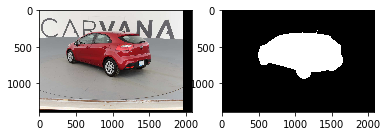

In [11]:
def random_scale_shift(image_pair, shift_limit=(-0.0625, 0.0625), 
                scale_limit=(-0.1, 0.1)):
    """
    the output image size may be different from the input
    """
    image, label = image_pair
    shift_x = random.uniform(shift_limit[0], shift_limit[1])
    shift_y = random.uniform(shift_limit[0], shift_limit[1])
    scale = random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
    
    w, h = image.size
    
    image = image.resize((round(w * scale), round(h * scale)), resample=Image.BILINEAR)
    label = label.resize((round(w * scale), round(h * scale)), resample=Image.NEAREST)
    
    # shift
    w, h = image.size
    image = shift_image(image, shift_x * w, shift_y * h)
    lable = shift_image(label, shift_x * w, shift_y * h)
    return image, label

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = random_scale_shift((image_, mask_))
show_image_and_mask(image_, mask_)

In [12]:
transforms = []

transforms.append(lambda image_pair: random_horizontal_flip(image_pair))
transforms.append(lambda image_pair: random_rotate(image_pair))
transforms.append(lambda image_pair: random_scale_shift(image_pair))
print (transforms)

[<function <lambda> at 0x7fd50feed268>, <function <lambda> at 0x7fd50feed510>, <function <lambda> at 0x7fd50ff67510>]


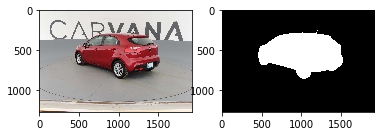

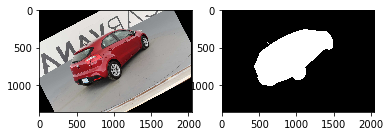

In [13]:
def apply_transforms(image, mask, transforms):
    #pdb.set_trace()
    image_pair = (image, mask)
    assert transforms is not None
    for transform in transforms:
        image, mask = transform(image_pair)
        image_pair = (image, mask)
    return image, mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = apply_transforms(image_, mask_, transforms)
show_image_and_mask(image_, mask_)

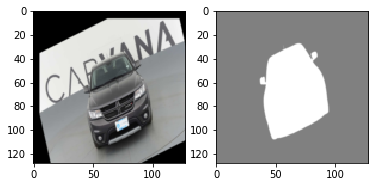

In [14]:
# Generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims, transforms=None):
    """
    data_dir: where the actual images are kept
    mask_dir: where the actual masks are kept
    images: the filenames of the images we want to generate batches from
    dims: the dimensions in which we want to rescale our images
    transforms: the list of transforms to be applied to image and mask in order,
                only apply to training data
    """
    if batch_size == 0:
        img_number = len(images)
        all_imgs = np.zeros([img_number] + dims + [3], dtype=np.float32)
        all_masks = np.zeros([img_number] + dims, dtype=np.float32)
        print('Build generator, this may take some time...')
        print('total number of images: {}'.format(img_number))
        for i, image in enumerate(tqdm(images)):
            # Image
            original_image = load_img(data_dir + image)
            resized_img = imresize(original_image, dims + [3])
            array_img = img_to_array(resized_img) / 255
            all_imgs[i] = array_img
            # Mask
            mask = load_img(mask_dir + image.split('.')[0] + '_mask.gif')
            resized = imresize(mask, dims + [3])
            array = img_to_array(resized) / 255
            all_masks[i] = array[:,:,0]
        while True:
            yield all_imgs, all_masks[:,:,:,None]
    else:
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                original_img, original_mask = \
                    read_image_and_mask(data_dir, mask_dir, images[i])
                
                # Apply transform
                if transforms:
                    transformed_img, transformed_mask = \
                        apply_transforms(original_img, original_mask, transforms)
                    resized_img = imresize(transformed_img, dims+[3])
                    resized_mask = imresize(transformed_mask, dims+[3])
                else:
                    resized_img = imresize(original_img, dims+[3])
                    resized_mask = imresize(original_mask, dims+[3])
                # images
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 32, 
                          [128, 128], transforms=transforms)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [15]:
class threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by serializing
    call to the 'next' method of given iterator/generator.
    """
    def __init__(self, it):
        import threading
        self.it = it
        self.lock = threading.Lock()
        
    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return next(self.it)

In [16]:
%%time
_ = next(train_gen)

CPU times: user 5.1 s, sys: 152 ms, total: 5.26 s
Wall time: 5.72 s


In [17]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, 0, [128, 128])

In [18]:
_ = next(val_gen)

  0%|          | 1/1018 [00:00<01:46,  9.51it/s]

Build generator, this may take some time...
total number of images: 1018


100%|██████████| 1018/1018 [01:40<00:00, 10.16it/s]


## Build the network

In [19]:
# First, let's define the two different types of layers that we will 
# be using
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool,residual
    else:
        return residual
    
def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same')(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(
        conv1)
    return conv2


In [54]:
# Make a custom U-nets implementation

filters = 64
input_layer = Input(shape=[128, 128, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1
up1 = up(d5, residual=residuals[-1], filters=filters/2)
filters /= 2

# Up 2,3,4
up_ = up1
for layer_i in range(3):
    up_ = up(up_, residual=residuals[-(layer_i + 2)], filters=filters/2)
    filters /= 2
    
# Out, or up 5
out = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(up_)

model = Model(input_layer, out)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_70 (Conv2D)               (None, 128, 128, 64)  1792        input_4[0][0]                    
____________________________________________________________________________________________________
conv2d_71 (Conv2D)               (None, 128, 128, 64)  36928       conv2d_70[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D)  (None, 64, 64, 64)    0           conv2d_71[0][0]                  
___________________________________________________________________________________________

In [55]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [56]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath='./tmp/weight.hdf5', verbose=1, save_best_only=True)
# Logger
csv_logger = CSVLogger('./tmp/training.log')

In [39]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [57]:
# Training time!
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', 
             metrics=[dice_coef])

In [52]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=128, 
                              callbacks=[checkpoint, csv_logger], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=3, 
                              epochs=20, 
                              initial_epoch=0)

np.save('./tmp/history', history.history)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<__main__...., validation_data=(array([[[..., workers=3, epochs=20, validation_steps=inf, steps_per_epoch=128, initial_epoch=0, max_queue_size=6, callbacks=[<keras.ca...)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20


KeyboardInterrupt: 

In [46]:
np.save('./tmp/history', history.history)

In [48]:
history = np.load('./tmp/history.npy')

In [49]:
history

array({'val_dice_coef': [0.0], 'val_loss': [0.32206201529924433], 'loss': [0.31922167539596558], 'dice_coef': [0.0]}, dtype=object)